# Relatório Regras de Associação - Nicholas Richers

# Linguagem:
* Para a realização dessa análise foi utilizada a linguagem __python (v.3.6)__, com o auxílio das bibliotecas __Pandas__ e __Mlextend__

In [1]:
#bibliotecas utilizadas
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Preparação dos Dados:

* Limpeza do dataset:
    * Obs: Haviam 18 filmes com Id duplicado, que foram removidos

In [2]:
#carregando os datasets de ratings
ratings_100k = pd.read_csv('./ml-100k/u.data', header=None, delimiter="\t" )
ratings_1M = pd.read_csv('./ml-1m/ratings.dat', header=None, delimiter=":" )


#carregando os datasets de filmes
movies_100k = pd.read_csv('./ml-100k/u.item', header=None, sep='|' , encoding='latin-1')
movies_1M = pd.read_csv('./ml-1m/movies.dat', header=None, sep=';' , encoding='latin-1')

In [3]:
#funcão para limpar os datasets
def setup_BD(ratings, movies):
    
    #retira as colunas 2 e 3 da tabela rating e renomeia
    ratings.drop([2,3], axis=1, inplace=True)
    ratings.columns = ['User', 'Movie_Id']
    
    #seleciona apenas as colunas 0 e 1 da tabela movies e renomeia
    movies = movies.loc[:,[0,1]]
    movies.columns = ['Movie_Id', 'Movie']
    
    
    #Crinado um merge dos 2 datasets
    ratings = ratings.merge(movies,on='Movie_Id')
    ratings = ratings.loc[:,['User', 'Movie']]
    ratings.sort_values('User').head()
    
    
    #Limpando os registros duplicados
    ratings = ratings.drop_duplicates(keep='first')
    
    return ratings, movies

#obter os datasets limpos
ratings_100k, movies_100k = setup_BD(ratings_100k, movies_100k)
ratings_1M, movies_1M = setup_BD(ratings_1M, movies_1M)

# Criação das Regras de Associação

* Passo 1: Criar uma __tabela pivot__ com os filmes vistos por cada usuário em formato de vetor [0,1].


* Passo 2: Através do __algoritmo apriori__ selecionamos o item (ou grupo de itens, com max_len=2), para um __suporte mínimo__ desejado.


* Passo 3: Finalmente, devemos gerar as __regra de associacão__ para o __nível de confiança__ desejado.

In [4]:
# Coloca 0 e 1 em todos os elementos do vetor
def hot_encoded(x):
    if x == 0: return 0     
    else: return 1  


def create_rules(ratings,sup,con):
    
    #1 Cria uma tabela pivot
    basket = (ratings.pivot(index='User', columns='Movie', values='User').fillna(0))
    basket_sets = basket.applymap(hot_encoded)
    
    #2 Algoritmo apriori com regra de tamanho 2, e suporte mínimo
    frequent_itemsets = apriori(basket_sets, min_support=sup, use_colnames=True, max_len=2)
    
    #3 cria as regras de associacao para a confiança
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=con)
    print('Suporte = {}, Confiaça = {}, Qtde. Regras = {}'.format(sup, con, rules.antecedents.count()))

    
    return basket_sets, rules


suport = 0.3
confidence = 0.58

print("Dataset 100k:")
basket_sets_100k, rules_100k = create_rules(ratings_100k,suport, confidence)

print("\nDataset 1M:")
basket_sets_1M, rules_1M= create_rules(ratings_1M, suport, confidence)

Dataset 100k:
Suporte = 0.3, Confiaça = 0.58, Qtde. Regras = 100

Dataset 1M:
Suporte = 0.3, Confiaça = 0.58, Qtde. Regras = 40


# Regras Adicionais

* Devemos criar algumas regras adicionais não inclusas na bibilioteca utilizada para completar a tabela de regras solicitada.

## Lift (B,!C)

$$Lift(B,!C) = (Suporte(B) - Suporte) / (1 - Suporte(C))$$

## $\chi^{2}$ Test
* De acordo com [1], podemos obter $\chi^{2}$ em função do suporte, da confiança e do Lift, logo temos:

\begin{equation}
  \chi^{2} = \frac{P(B) P(C)}{((1-P(B)) (1-P(C)))}
\end{equation}


[1] S. Alvarez.  Chi-squared computation for association rules: preliminary results.  Computer ScienceDept. Boston College, 2003

In [5]:
def additional_rules(rules,basket_sets):
    
    
    #cria regra Lift(B,!C)
    rules['neg_lift'] = ((rules['antecedent support']-rules['support'])/(1-rules['consequent support']))
    
    
    #cria regra chi-squared
    rules['chi_sq'] = basket_sets.shape[1]* ((rules['antecedent support']*rules['consequent support'])/
                                             (1-rules['antecedent support'])*(1-rules['consequent support']))
    
    
    #cria tabela apenas com os parâmetros pedidos
    rules = rules.loc[:, ['antecedents', 'consequents', 'support', 'confidence', 'lift', 'neg_lift', 'chi_sq']]
    

    return rules

rules_100k = additional_rules(rules_100k, basket_sets_100k)
rules_1M = additional_rules(rules_1M, basket_sets_1M)

# Análise das Regras
## Dataset 100k

* Ao ordenar as melhores regras pelo "Lift",  não foi encontrad __nenhuma relação__ com as melhores regras através do "Chi_Sq", através das duas tabelas abaixo, percebe-se que não há __nenhuma repetição de regra__, nem de antedecente, e apenas um consequente (Independence Day (ID4) (1996)) foi encontrado em ambos os casos.

In [6]:
#Dataset 100k ordenado pelo lift (5 maiores)
rules_100k.sort_values(['lift'], ascending=False).head()

,antecedents,consequents,support,confidence,lift,neg_lift,chi_sq
49,(Independence Day (ID4) (1996)),(Mission: Impossible (1996)),0.332980,0.731935,2.006437,0.191987,321.817291
48,(Mission: Impossible (1996)),(Independence Day (ID4) (1996)),0.332980,0.912791,2.006437,0.058366,236.963779
18,(Raiders of the Lost Ark (1981)),"(Empire Strikes Back, The (1980))",0.346766,0.778571,2.000525,0.161458,317.662600
17,"(Empire Strikes Back, The (1980))",(Raiders of the Lost Ark (1981)),0.346766,0.891008,2.000525,0.076482,261.893365
59,(Raiders of the Lost Ark (1981)),(Indiana Jones and the Last Crusade (1989)),0.306469,0.688095,1.960344,0.214052,304.408625


In [7]:
#Dataset 100k ordenado pelo chi_sq (5 maiores)
rules_100k.sort_values(['chi_sq'], ascending=False).head()

,antecedents,consequents,support,confidence,lift,neg_lift,chi_sq
97,(Star Wars (1977)),(Toy Story (1995)),0.404030,0.653516,1.363420,0.411405,672.536590
86,(Star Wars (1977)),(Return of the Jedi (1983)),0.509014,0.823328,1.531357,0.236239,669.869862
34,(Star Wars (1977)),(Fargo (1996)),0.417815,0.675815,1.254514,0.434483,669.651675
54,(Star Wars (1977)),(Independence Day (ID4) (1996)),0.383881,0.620926,1.364880,0.429961,668.215279
78,(Star Wars (1977)),(Raiders of the Lost Ark (1981)),0.402969,0.651801,1.463449,0.388145,665.651584


### Análise adicional (Dataset 100k):
* Contudo ao analisar o gráfico abaixo, podemos perceber que o lift possui uma __correlação positiva__ com a confiança, apesar do comportamento um tanto errático, já com o chi_sq, a __correlação__ passa a ser __negativa__.

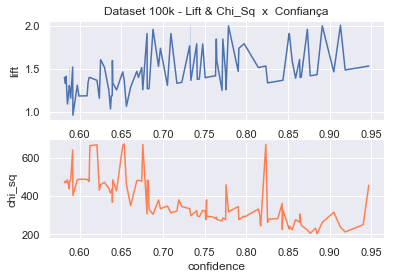

In [15]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.title('Dataset 100k - Lift & Chi_Sq  x  Confiança')
sns.lineplot(x="confidence", y="lift", data=rules_100k)             

plt.subplot(212)
sns.lineplot(x="confidence", y="chi_sq",  color="coral", data=rules_100k)

plt.show()

## Dataset 1M

* Para o dataset 1M nas duas tabelas abaixo, chegamos a uma conclusão semelhante ao dataset 100k

In [9]:
#Dataset 1M ordenado pelo lift (5 maiores)
rules_1M.sort_values(['lift'], ascending=False).head()

,antecedents,consequents,support,confidence,lift,neg_lift,chi_sq
23,(Terminator 2: Judgment Day (1991)),"(Matrix, The (1999))",0.327483,0.746697,1.741332,0.194493,709.095232
22,"(Matrix, The (1999))",(Terminator 2: Judgment Day (1991)),0.327483,0.763707,1.741332,0.180478,685.049502
11,(Men in Black (1997)),(Jurassic Park (1993)),0.321026,0.763987,1.726977,0.177850,662.545259
10,(Jurassic Park (1993)),(Men in Black (1997)),0.321026,0.725674,1.726977,0.209309,716.314378
25,(Terminator 2: Judgment Day (1991)),(Men in Black (1997)),0.307119,0.700264,1.666508,0.226728,705.331802


In [10]:
#Dataset 1M ordenado pelo chi_sq (5 maiores)
rules_1M.sort_values(['chi_sq'], ascending=False).head()

,antecedents,consequents,support,confidence,lift,neg_lift,chi_sq
30,(Star Wars: Episode IV - A New Hope (1977)),(Star Wars: Episode V - The Empire Strikes Bac...,0.389901,0.787362,1.590524,0.208525,908.785845
31,(Star Wars: Episode V - The Empire Strikes Bac...,(Star Wars: Episode IV - A New Hope (1977)),0.389901,0.787625,1.590524,0.208265,908.190018
32,(Star Wars: Episode IV - A New Hope (1977)),(Star Wars: Episode VI - Return of the Jedi (1...,0.349834,0.706453,1.480047,0.278112,907.005145
36,(Star Wars: Episode V - The Empire Strikes Bac...,(Star Wars: Episode VI - Return of the Jedi (1...,0.368874,0.745151,1.561120,0.241368,906.404621
12,(Star Wars: Episode IV - A New Hope (1977)),(Jurassic Park (1993)),0.301987,0.609829,1.378507,0.346496,896.807152


### Análise Adicional (Dataset 1M):
* Para o dataset 1M, com menos regras, apesar de bastante errático, ainda podemos perceber o mesmo comportamento das regras selecionadas em relação ao lift e chi_sq versus confiança.


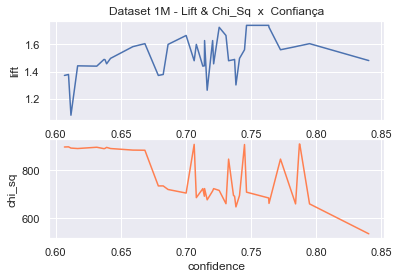

In [11]:
plt.figure(1)
plt.subplot(211)
plt.title('Dataset 1M - Lift & Chi_Sq  x  Confiança')
sns.lineplot(x="confidence", y="lift", data=rules_1M)             

plt.subplot(212)
sns.lineplot(x="confidence", y="chi_sq",  color="coral", data=rules_1M)

plt.show()

# Análse Comparariva

* Por fim ao comparar as regras selecionadas nos 2 datasets, percebemos que há pouca interseção entre elas, apenas __4 antecedentes e 2 consequentes__ estão contidos nas duas regras, além disso não há __nenhuma regra idêntica__.

In [12]:
#Antecedentes em ambas as listas de regras  
antecedents_list = [ant for ant in rules_1M.antecedents.unique() if ant in rules_100k.antecedents.unique()]        
print("Número de Antecedentes nas regras dos dois datasets:", len(antecedents_list))
antecedents_list

Número de Antecedentes nas regras dos dois datasets: 4


[frozenset({'Fargo (1996)'}),
 frozenset({'Silence of the Lambs, The (1991)'}),
 frozenset({'Back to the Future (1985)'}),
 frozenset({'Raiders of the Lost Ark (1981)'})]

In [13]:
#consequentes em ambas as listas de regras  
consequents_list = [con for con in rules_1M.consequents.unique() if con in rules_100k.consequents.unique()]        
print("Número de Consequentes nas regras dos dois datasets:", len(consequents_list))
consequents_list

Número de Consequentes nas regras dos dois datasets: 2


[frozenset({'Back to the Future (1985)'}),
 frozenset({'Raiders of the Lost Ark (1981)'})]

In [14]:
rules_list_100k = [(a,b) for a,b in zip(rules_100k.antecedents, rules_100k.consequents)]
rules_list_1M = [(a,b) for a,b in zip(rules_1M.antecedents, rules_1M.consequents)]
print("Numero de regras idêntica:", len([rule for rule in rules_list_1M if rule in rules_list_100k]))

Numero de regras idêntica: 0
